## Basic Ridge Regression

In [1]:
import sys
sys.path.append('../../furry-couscous/')
from scanpy_utils import cnmf_load_results

In [2]:
sys.path.append('../')
from qc_pipeline import *
sc.settings.set_figure_params(dpi=80, color_map='viridis')

In [6]:
# working
del sys.modules['qc_pipeline']
from qc_pipeline import *

### Load data and preprocess

In [10]:
s2 = sc.read_h5ad('../data/colon_10x.h5ad')
# see how many "good cells" Ken labeled (1)
s2.obs['ken_filter'].value_counts()

1    3954
0    1046
Name: ken_filter, dtype: int64

In [11]:
%%time
# 1) preprocess counts and calculate required QC metrics
recipe_fcc(
    s2,
    X_final="arcsinh_norm",
    mito_names="^mt-",
    n_hvgs=2000,
    target_sum=None,
)

../QC.py:122: UserWarning: Encountered 10354 genes with 0 cells by counts. Consider removing these before proceeding (i.e. sc.pp.filter_genes(adata,min_cells=1))
  np.size(nt) - np.count_nonzero(nt)


CPU times: user 6.23 s, sys: 1.38 s, total: 7.6 s
Wall time: 7.6 s


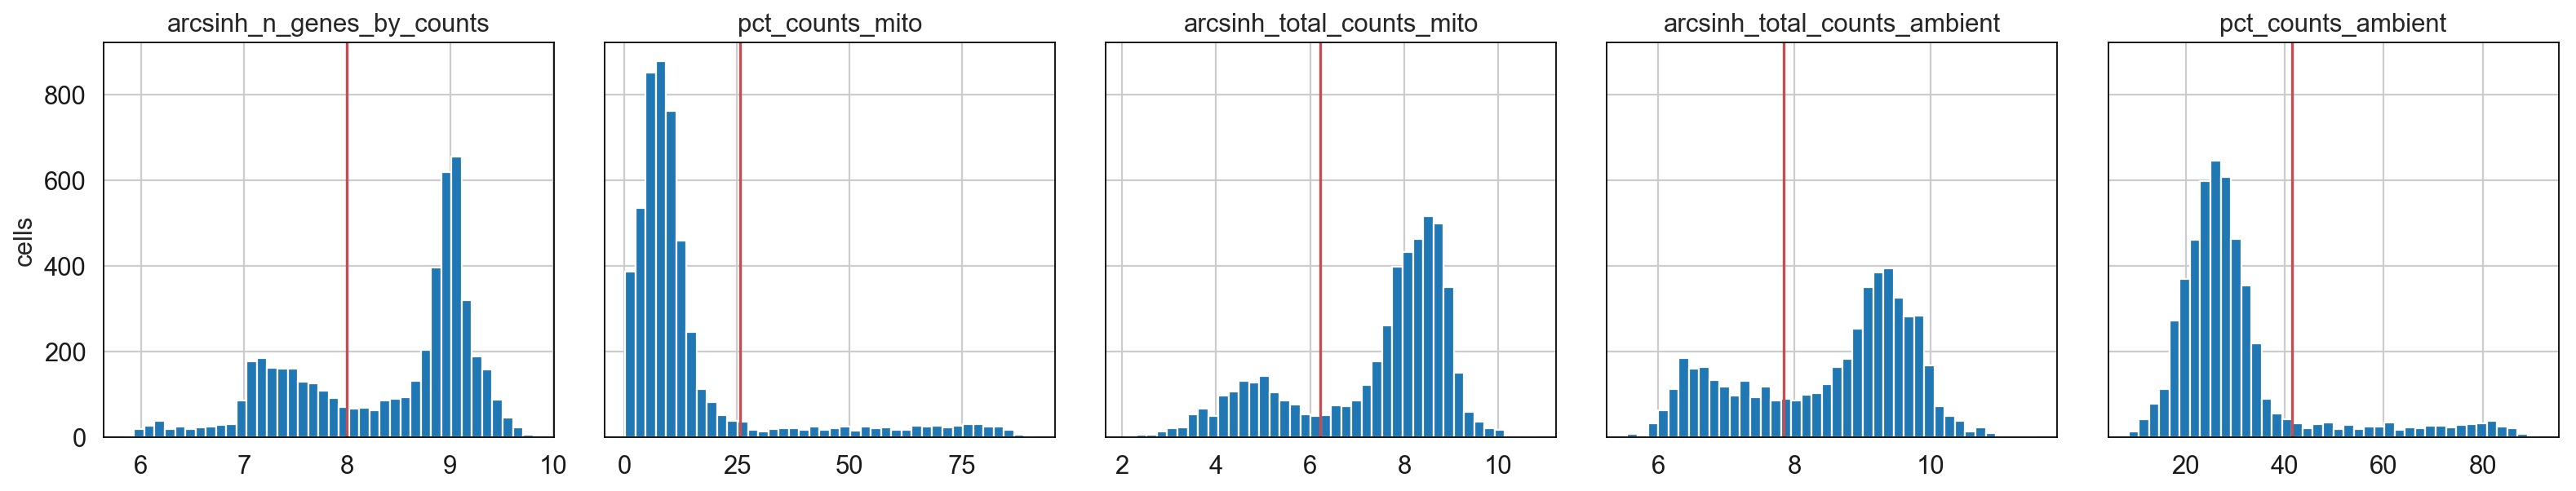

In [13]:
# 2) threshold chosen heuristics using automated method
adata_thresh = auto_thresh_obs(
    s2,
    method="li",
    obs_cols=["arcsinh_n_genes_by_counts","pct_counts_mito","arcsinh_total_counts_mito","arcsinh_total_counts_ambient","pct_counts_ambient"]
)
plot_thresh_obs(s2, adata_thresh)

In [3]:
%%time
thresh0, rc0 = ridge_pipe(
    s2,
    mito_names="^mt-",
    n_hvgs=2000,
    thresh_method="li",
    obs_cols=[
        "pct_counts_mito",
        "arcsinh_n_genes_by_counts",
        #"arcsinh_total_counts",
    ],
    directions=[
        "below",
        "above",
        #"above",
    ],
    alphas=(100, 150, 200, 250, 300),
)

Preprocessing counts and generating metrics


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
../QC.py:122: UserWarning: Encountered 10354 genes with 0 cells by counts. Consider removing these before proceeding (i.e. sc.pp.filter_genes(adata,min_cells=1))
  np.size(nt) - np.count_nonzero(nt)


Thresholding on heuristics for training labels
Training ridge classifier with alpha values: (100, 150, 200, 250, 300)
Chosen alpha value: 300
Assigning scores and labels from model
Done!
CPU times: user 25.5 s, sys: 2.46 s, total: 28 s
Wall time: 11 s


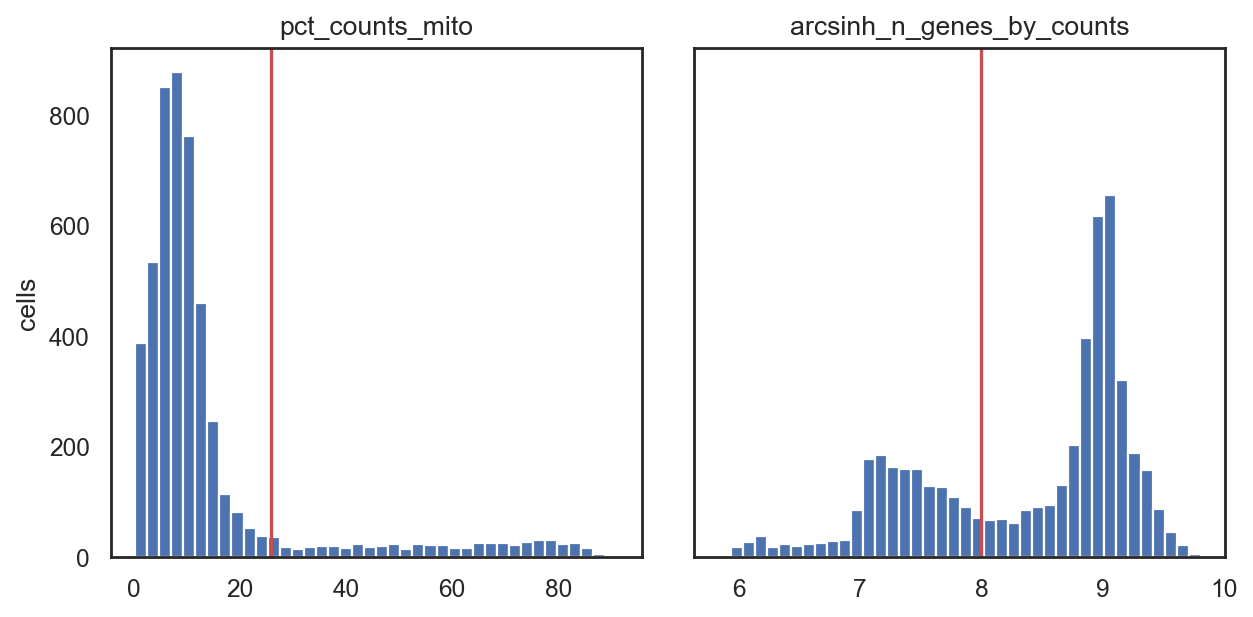

In [92]:
plot_thresh_obs(s2, thresh0)

/Users/cody/.virtualenvs/qc/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/Users/cody/.virtualenvs/qc/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


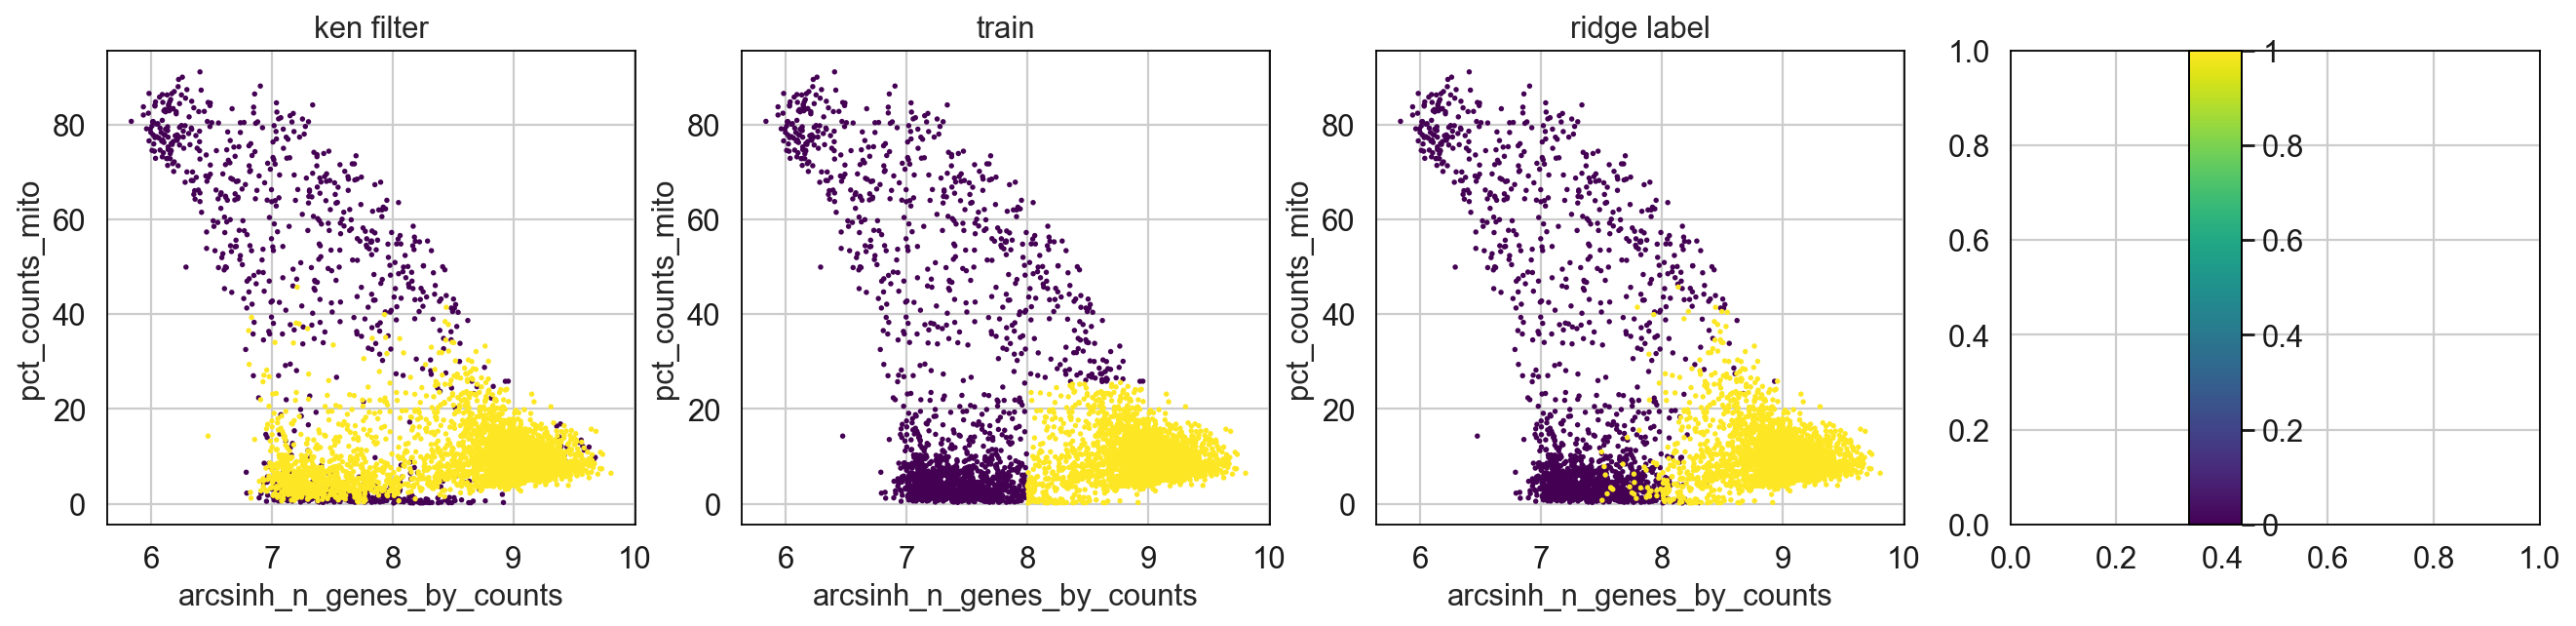

In [4]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,4))
sc.pl.scatter(s2, y='pct_counts_mito', x='arcsinh_n_genes_by_counts', color='ken_filter', ax=axes[0], show=False, legend_loc='none')
sc.pl.scatter(s2, y='pct_counts_mito', x='arcsinh_n_genes_by_counts', color='train', ax=axes[1], show=False, legend_loc='none')
sc.pl.scatter(s2, y='pct_counts_mito', x='arcsinh_n_genes_by_counts', color='ridge_label', ax=axes[2], show=False, legend_loc='none')
fig.show()

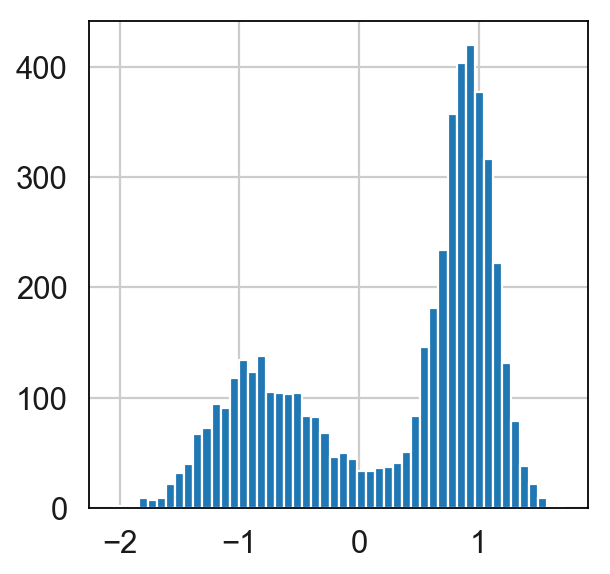

In [5]:
# distribution of scores
_ = plt.hist(s2.obs['ridge_score'], bins=50)

In [6]:
len(set(s2.obs_names[s2.obs['train']==1]) ^ set(s2.obs_names[s2.obs['ken_filter']==1]))

985

In [7]:
len(set(s2.obs_names[s2.obs['ridge_label']==1]) ^ set(s2.obs_names[s2.obs['train']==1]))

132

In [8]:
len(set(s2.obs_names[s2.obs['ridge_label']==1]) ^ set(s2.obs_names[s2.obs['ken_filter']==1]))

957

In [83]:
s2

AnnData object with n_obs × n_vars = 5000 × 27998 
    obs: 'ken_filter', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'ranked_total_counts', 'arcsinh_n_genes_by_counts', 'arcsinh_total_counts', 'gf_icf_total', 'log1p_norm_factor', 'train', 'ridge_score', 'ridge_label', 'compare', 'total_counts_ambient', 'arcsinh_total_counts_ambient', 'pct_counts_ambient'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ambient'
    layers: 'raw_counts', 'arcsinh_norm', 'gf_icf', 'log1p_norm'

In [89]:
s2.var_names[((s2.X.astype(bool).sum(axis=0) / s2.n_obs) >= 0.95)]

Index(['Rpl37a', 'Phgr1', 'Car1', 'Rps20', 'Rps8', 'Rplp0', 'Actb', 'Rpl21',
       'Rpl32', 'Rpl28', 'Rps16', 'Lgals4', 'Ftl1', 'Rpl18', 'Rps12', 'Rpl41',
       'Rpl18a', 'Cox4i1', 'Rpl13', 'Rps24', 'Tpt1', 'Hspa8', 'Rplp1',
       'Eef1a1', 'Lypd8', 'Rpl23', 'Rpl19', 'Krt19', 'Rps29', 'Rpl37', 'Krt8',
       'Rps10', 'Rps18', 'Gm42418', 'Rps14', 'Rpl17', 'Malat1', 'Fau', 'Cox8a',
       'Fth1', 'mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp6', 'mt-Co3',
       'mt-Nd4', 'mt-Cytb'],
      dtype='object')

In [90]:
s2.var[s2.var['ambient']==True].index

Index(['Rpl37a', 'Phgr1', 'Car1', 'Rps20', 'Rps8', 'Rplp0', 'Actb', 'Rpl21',
       'Rpl32', 'Rpl28', 'Rps16', 'Lgals4', 'Ftl1', 'Rpl18', 'Rps12', 'Rpl41',
       'Rpl18a', 'Cox4i1', 'Rpl13', 'Rps24', 'Tpt1', 'Hspa8', 'Rplp1',
       'Eef1a1', 'Lypd8', 'Rpl23', 'Rpl19', 'Krt19', 'Rps29', 'Rpl37', 'Krt8',
       'Rps10', 'Rps18', 'Gm42418', 'Rps14', 'Rpl17', 'Malat1', 'Fau', 'Cox8a',
       'Fth1', 'mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp6', 'mt-Co3',
       'mt-Nd4', 'mt-Cytb'],
      dtype='object')

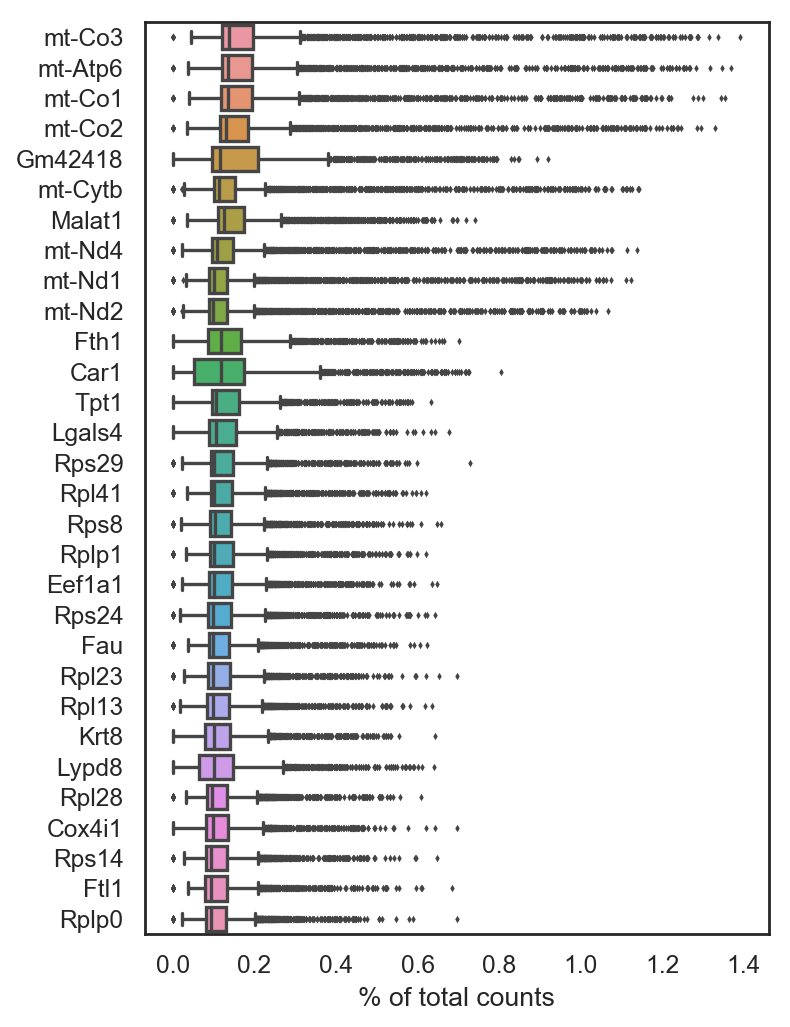

In [36]:
sc.pl.highest_expr_genes(s2)

In [76]:
s2.var['ambient'] = (s2.var['pct_dropout_by_counts']<=5)

In [49]:
s2.X = s2.layers['raw_counts'].copy()

In [77]:
s2.obs["total_counts_ambient"] = (
    s2.X[:, s2.var["ambient"].values].sum(axis=1)
)
s2.obs["arcsinh_total_counts_ambient"] = np.arcsinh(
    s2.obs["total_counts_ambient"]
)
s2.obs["pct_counts_ambient"] = (
    s2.obs["total_counts_ambient"]
    / s2.obs["total_counts"]
    * 100
)

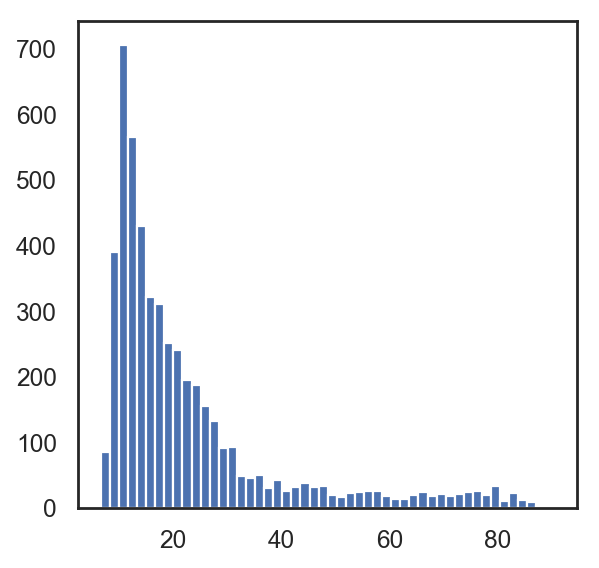

In [91]:
_ = plt.hist(s2.obs['pct_counts_in_top_10_genes'], bins=50)

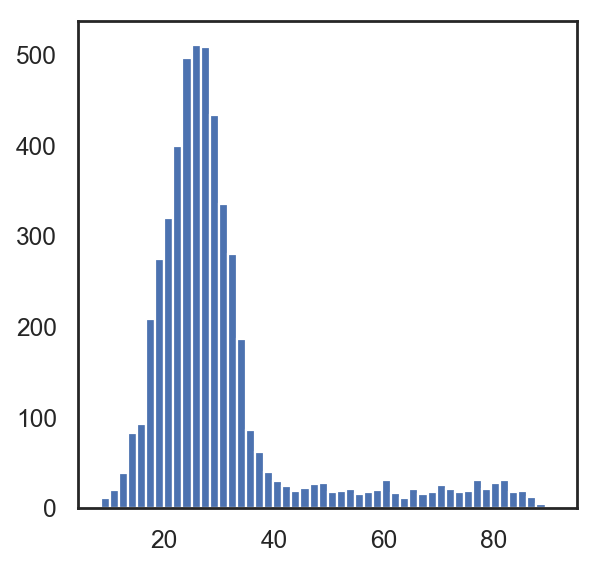

In [78]:
_ = plt.hist(s2.obs['pct_counts_ambient'], bins=50)

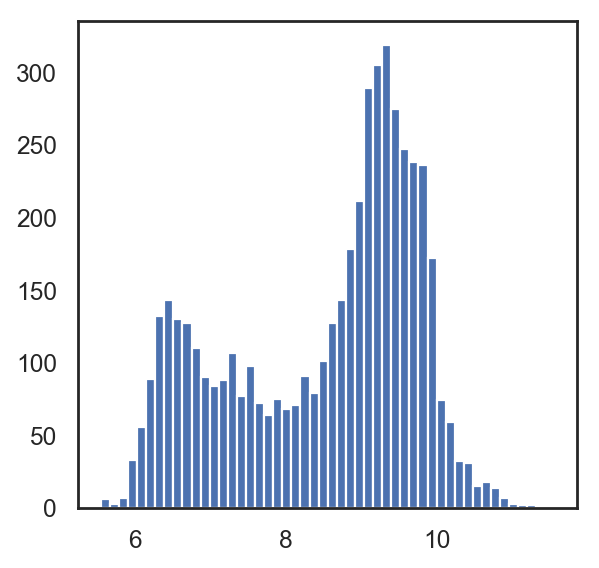

In [79]:
_ = plt.hist(s2.obs['arcsinh_total_counts_ambient'], bins=50)

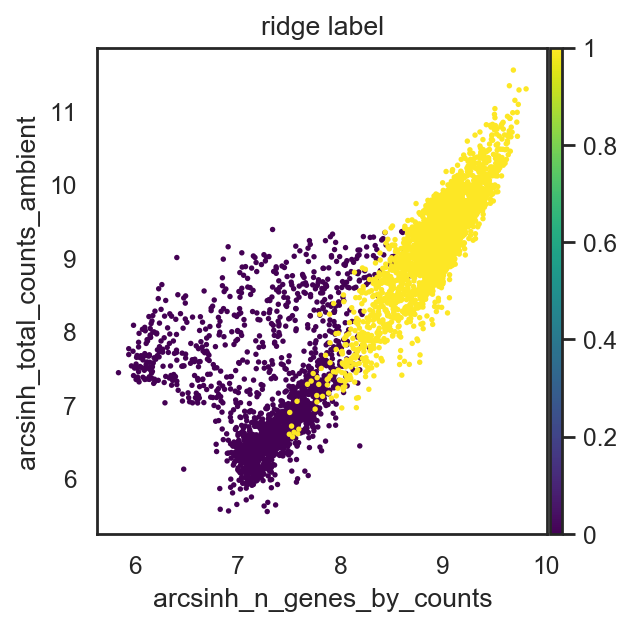

In [80]:
sc.pl.scatter(s2, x='arcsinh_n_genes_by_counts', y='arcsinh_total_counts_ambient', color='ridge_label', color_map='viridis')

---
#### Now, reduce dimensions and see how embeddings/cell populations change between the two filterings (Ken and TwoStep)

In [9]:
# generate obs column with ken vs twostep for visualization
s2.obs['compare'] = 'neither'
s2.obs.loc[(s2.obs['ken_filter']==1) & (s2.obs['ridge_label']==0), 'compare'] = 'manual'
s2.obs.loc[(s2.obs['ridge_label']==1) & (s2.obs['ken_filter']==0), 'compare'] = 'ridge'
s2.obs.loc[(s2.obs['ridge_label']==1) & (s2.obs['ken_filter']==1), 'compare'] = 'same'

In [25]:
# create new adata objects from filters
s2_ken = s2[s2.obs['ken_filter']==1,:].copy()
s2_ridge = s2[s2.obs['ridge_label']==1,:].copy()
s2_union = s2[(s2.obs['ken_filter']==1)|(s2.obs['ridge_label']==1), :].copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


---

In [11]:
# preprocess ken's dataset
s2_ken.X = s2_ken.layers['raw_counts'].copy()
recipe_fcc(s2_ken, X_final='arcsinh_norm', mito_names='^mt-')
s2_ken.obs['arcsinh_n_genes_by_counts'] = np.arcsinh(s2_ken.obs['n_genes_by_counts'])

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
../QC.py:122: UserWarning: Encountered 10420 genes with 0 cells by counts. Consider removing these before proceeding (i.e. sc.pp.filter_genes(adata,min_cells=1))
  np.size(nt) - np.count_nonzero(nt)


... storing 'compare' as categorical


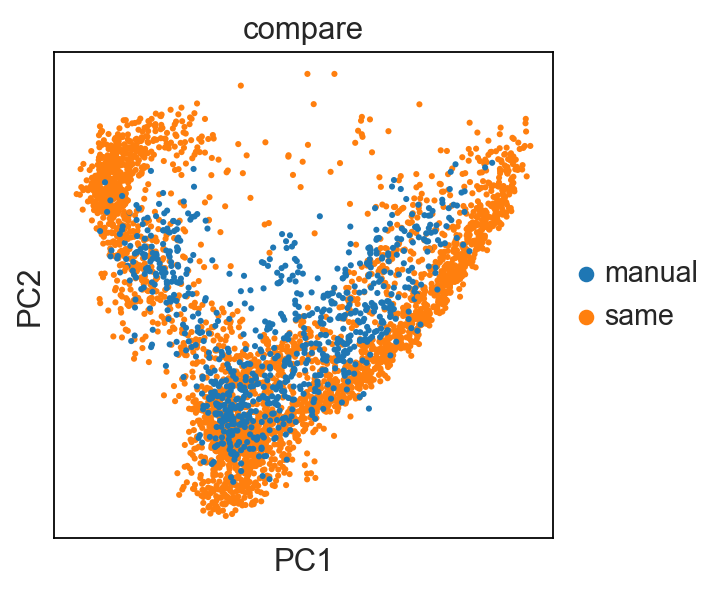

CPU times: user 2.27 s, sys: 354 ms, total: 2.63 s
Wall time: 499 ms


In [12]:
%%time
sc.tl.pca(s2_ken, n_comps=10)
sc.pl.pca(s2_ken, color=['compare'])

In [13]:
sc.pp.neighbors(s2_ken, n_neighbors=int(np.sqrt(s2_ken.n_obs)))
sc.tl.umap(s2_ken)

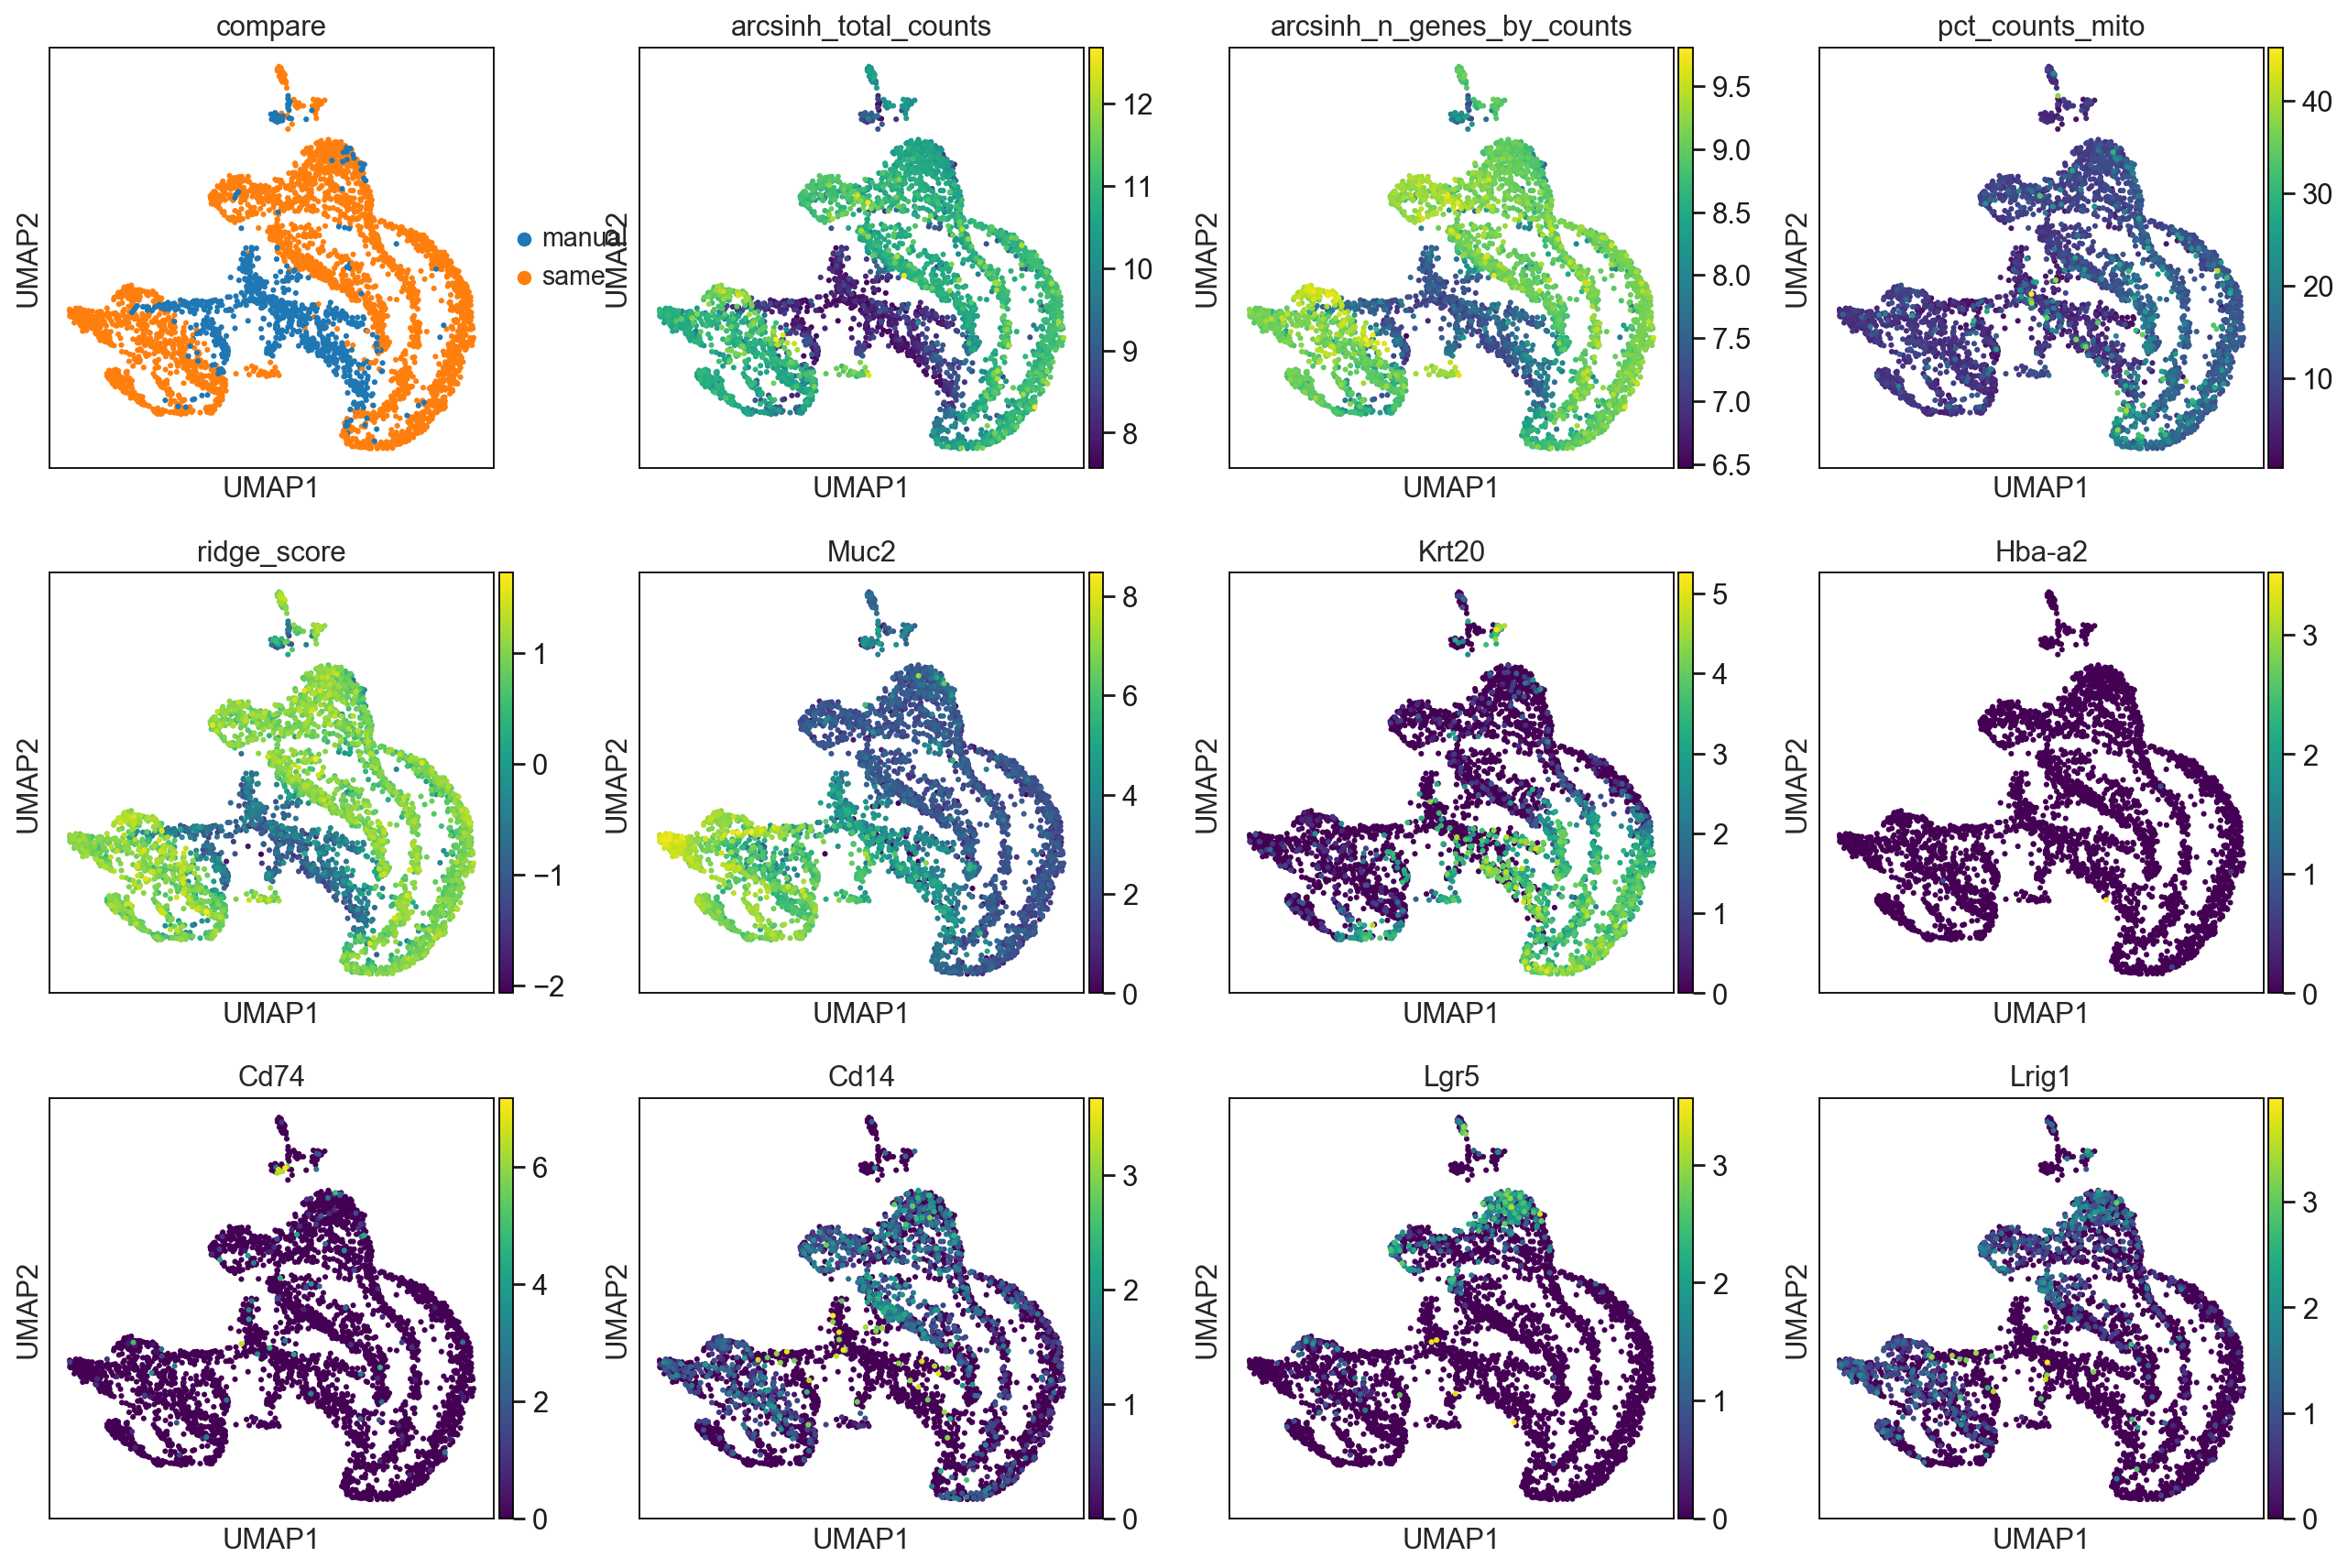

In [14]:
# show UMAP of Ken's data
sc.pl.umap(s2_ken, color=['compare','arcsinh_total_counts','arcsinh_n_genes_by_counts','pct_counts_mito','ridge_score','Muc2','Krt20','Hba-a2','Cd74','Cd14','Lgr5','Lrig1'])

---
#### Now do the same on RidgeClassifier results

In [15]:
# preprocess
s2_ridge.X = s2_ridge.layers['raw_counts'].copy()
recipe_fcc(s2_ridge, X_final='arcsinh_norm', mito_names='^mt-')
s2_ridge.obs['arcsinh_n_genes_by_counts'] = np.arcsinh(s2_ridge.obs['n_genes_by_counts'])

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
../QC.py:122: UserWarning: Encountered 10516 genes with 0 cells by counts. Consider removing these before proceeding (i.e. sc.pp.filter_genes(adata,min_cells=1))
  np.size(nt) - np.count_nonzero(nt)


... storing 'compare' as categorical


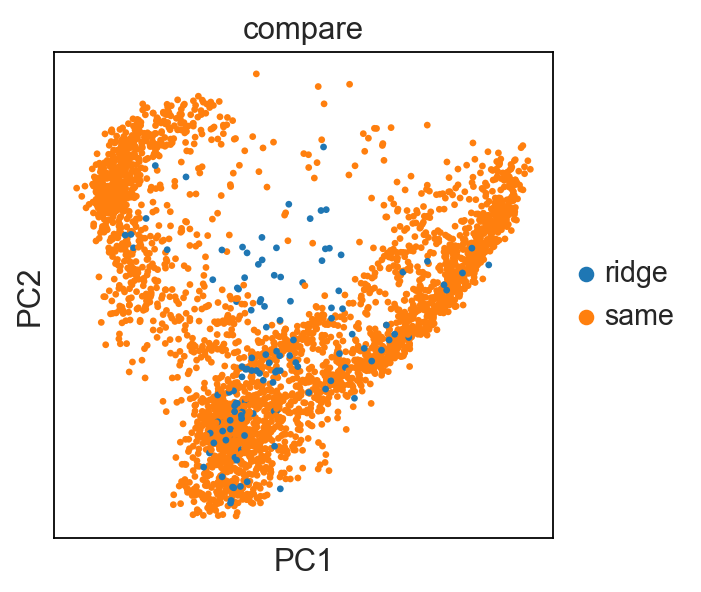

CPU times: user 2.01 s, sys: 321 ms, total: 2.33 s
Wall time: 419 ms


In [16]:
%%time
sc.tl.pca(s2_ridge, n_comps=10)
sc.pl.pca(s2_ridge, color=['compare'])

In [17]:
sc.pp.neighbors(s2_ridge, n_neighbors=int(np.sqrt(s2_ridge.n_obs)))
sc.tl.umap(s2_ridge)

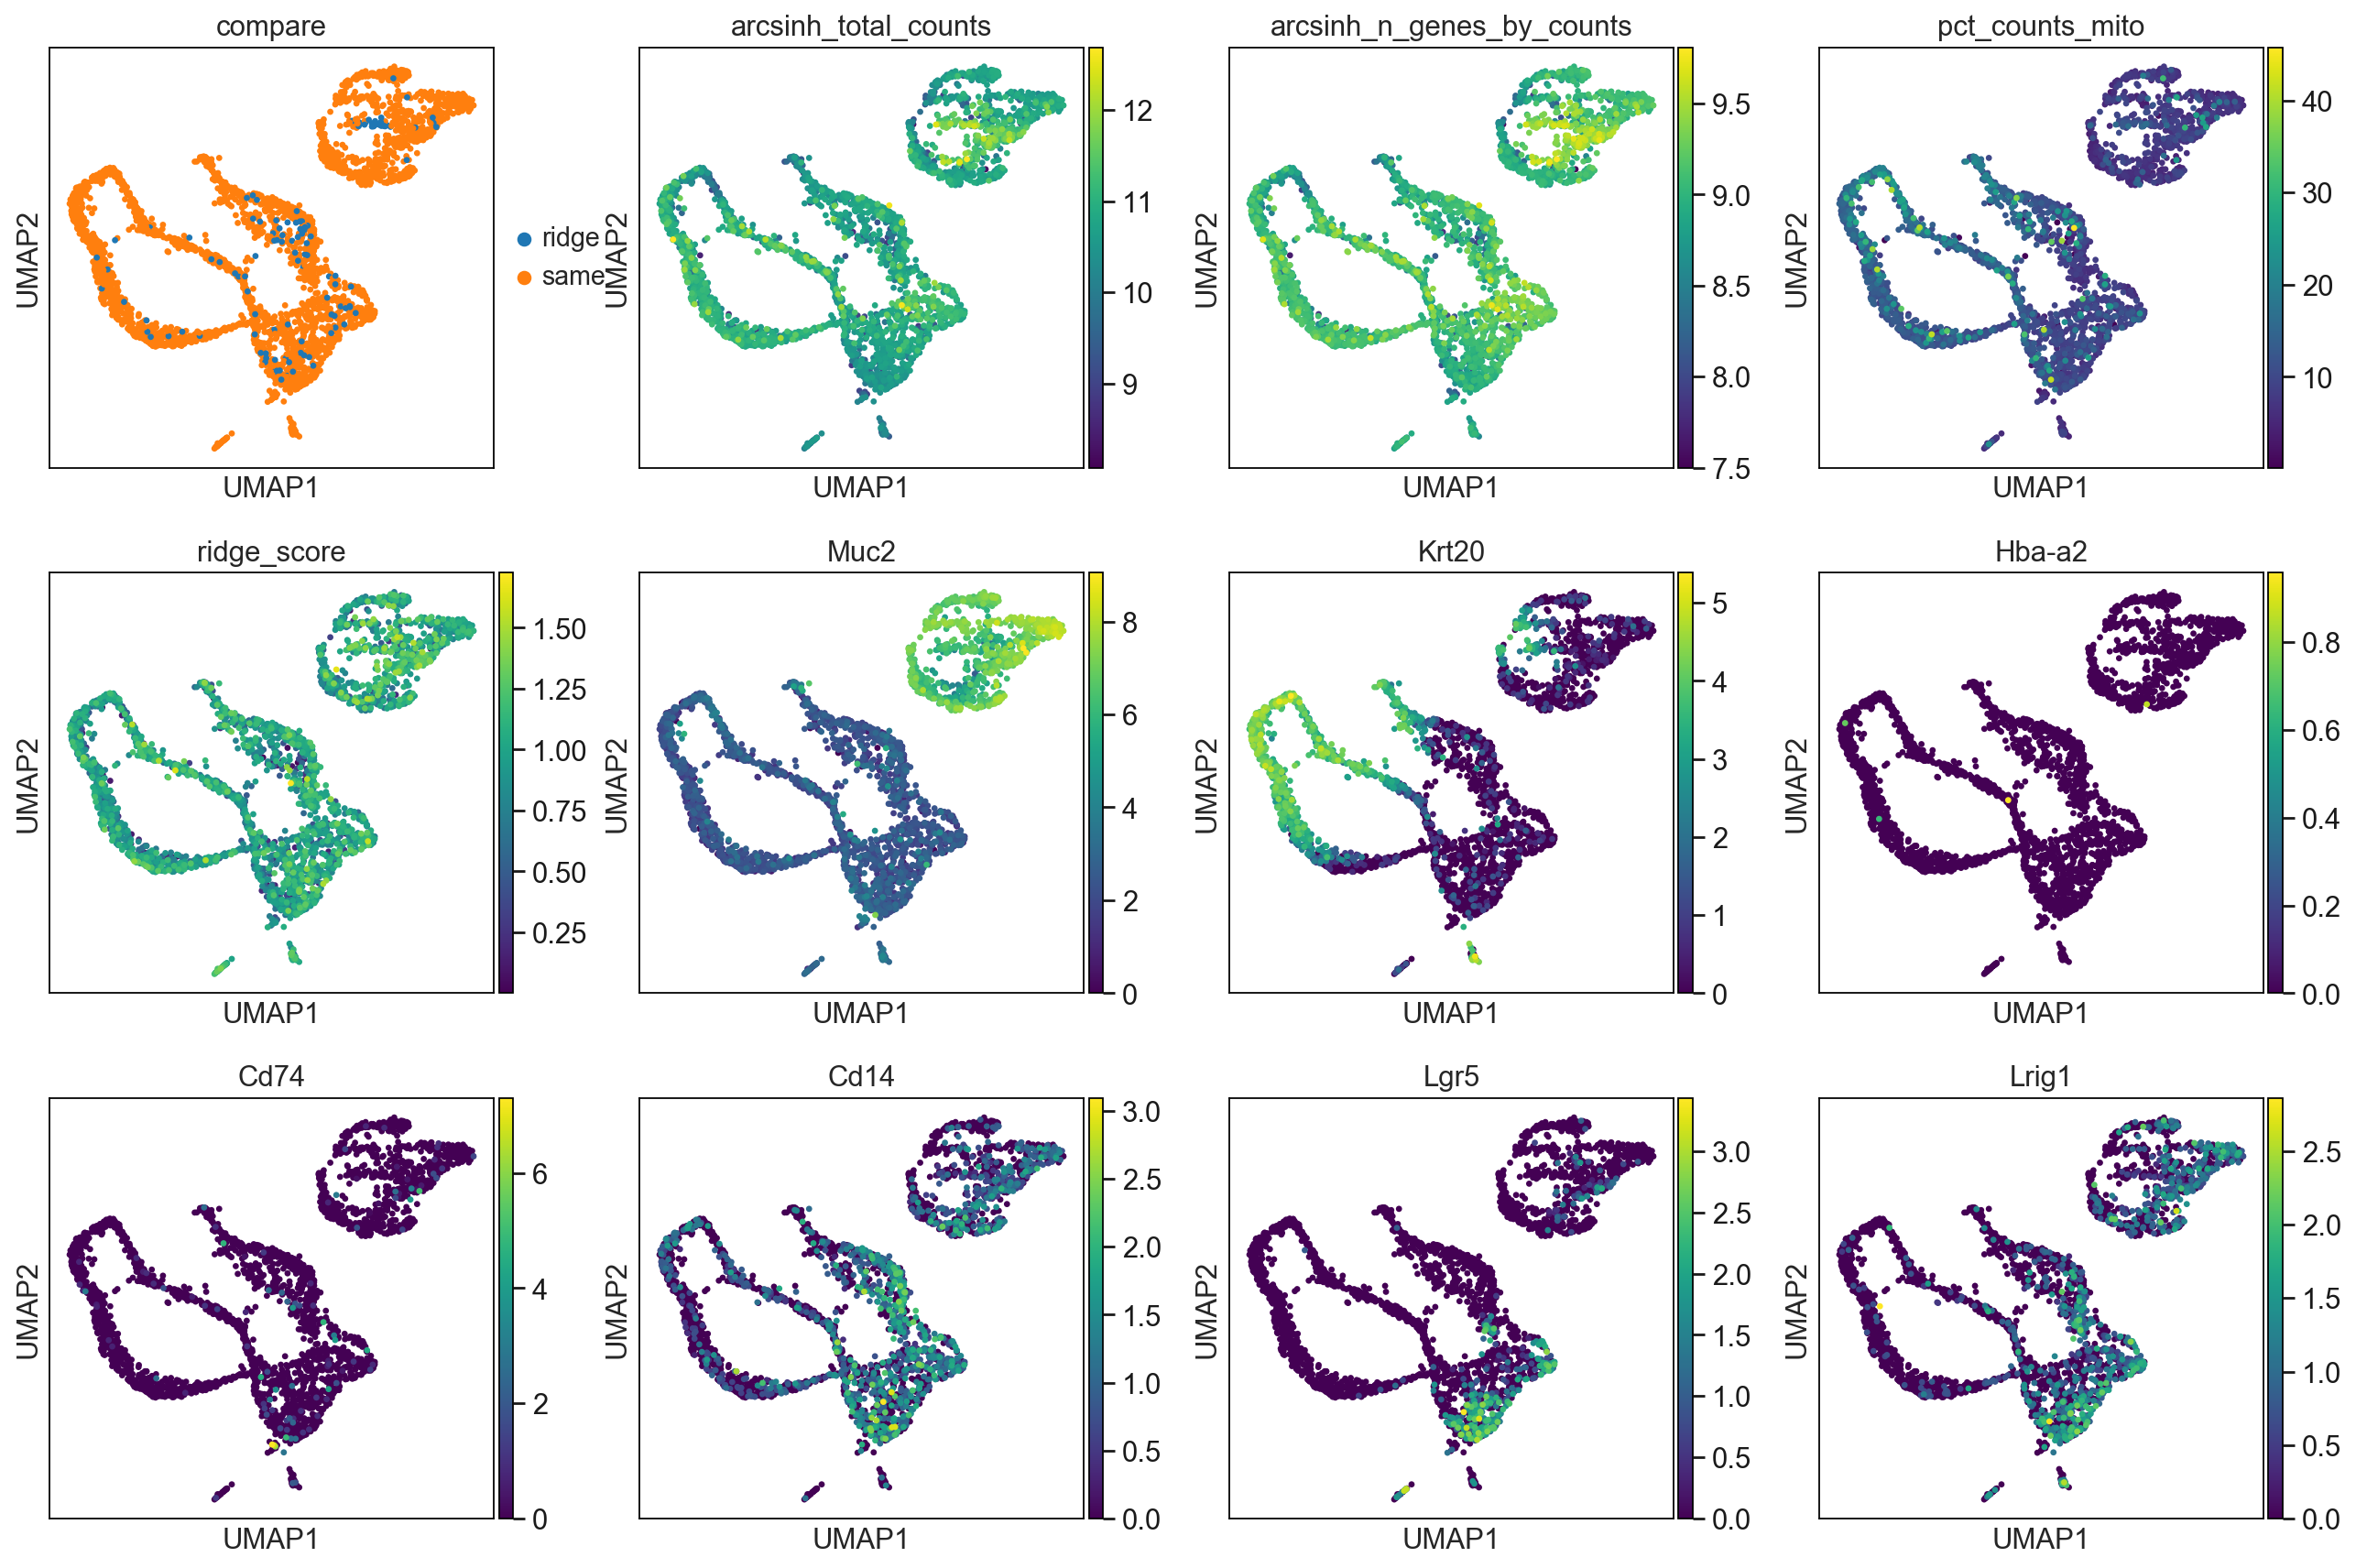

In [18]:
sc.pl.umap(s2_ridge, color=['compare','arcsinh_total_counts','arcsinh_n_genes_by_counts','pct_counts_mito','ridge_score','Muc2','Krt20','Hba-a2','Cd74','Cd14','Lgr5','Lrig1'])

---
#### Now do the same on with the union of the two results

In [26]:
# preprocess
s2_union.X = s2_union.layers['raw_counts'].copy()
recipe_fcc(s2_union, X_final='arcsinh_norm', mito_names='^mt-')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
../QC.py:122: UserWarning: Encountered 10399 genes with 0 cells by counts. Consider removing these before proceeding (i.e. sc.pp.filter_genes(adata,min_cells=1))
  np.size(nt) - np.count_nonzero(nt)


... storing 'compare' as categorical


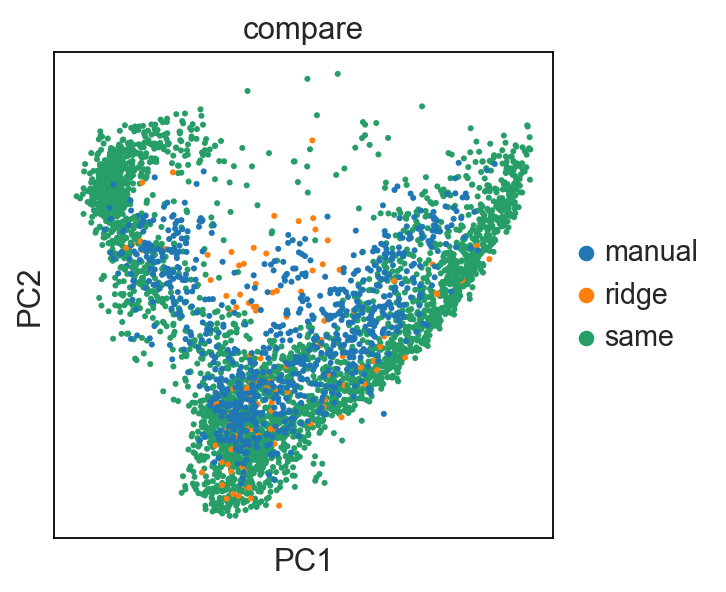

CPU times: user 2.25 s, sys: 426 ms, total: 2.68 s
Wall time: 515 ms


In [27]:
%%time
sc.tl.pca(s2_union, n_comps=10)
sc.pl.pca(s2_union, color=['compare'])

In [28]:
sc.pp.neighbors(s2_union, n_neighbors=int(np.sqrt(s2_union.n_obs)))
sc.tl.umap(s2_union)

In [29]:
sc.tl.louvain(s2_union)

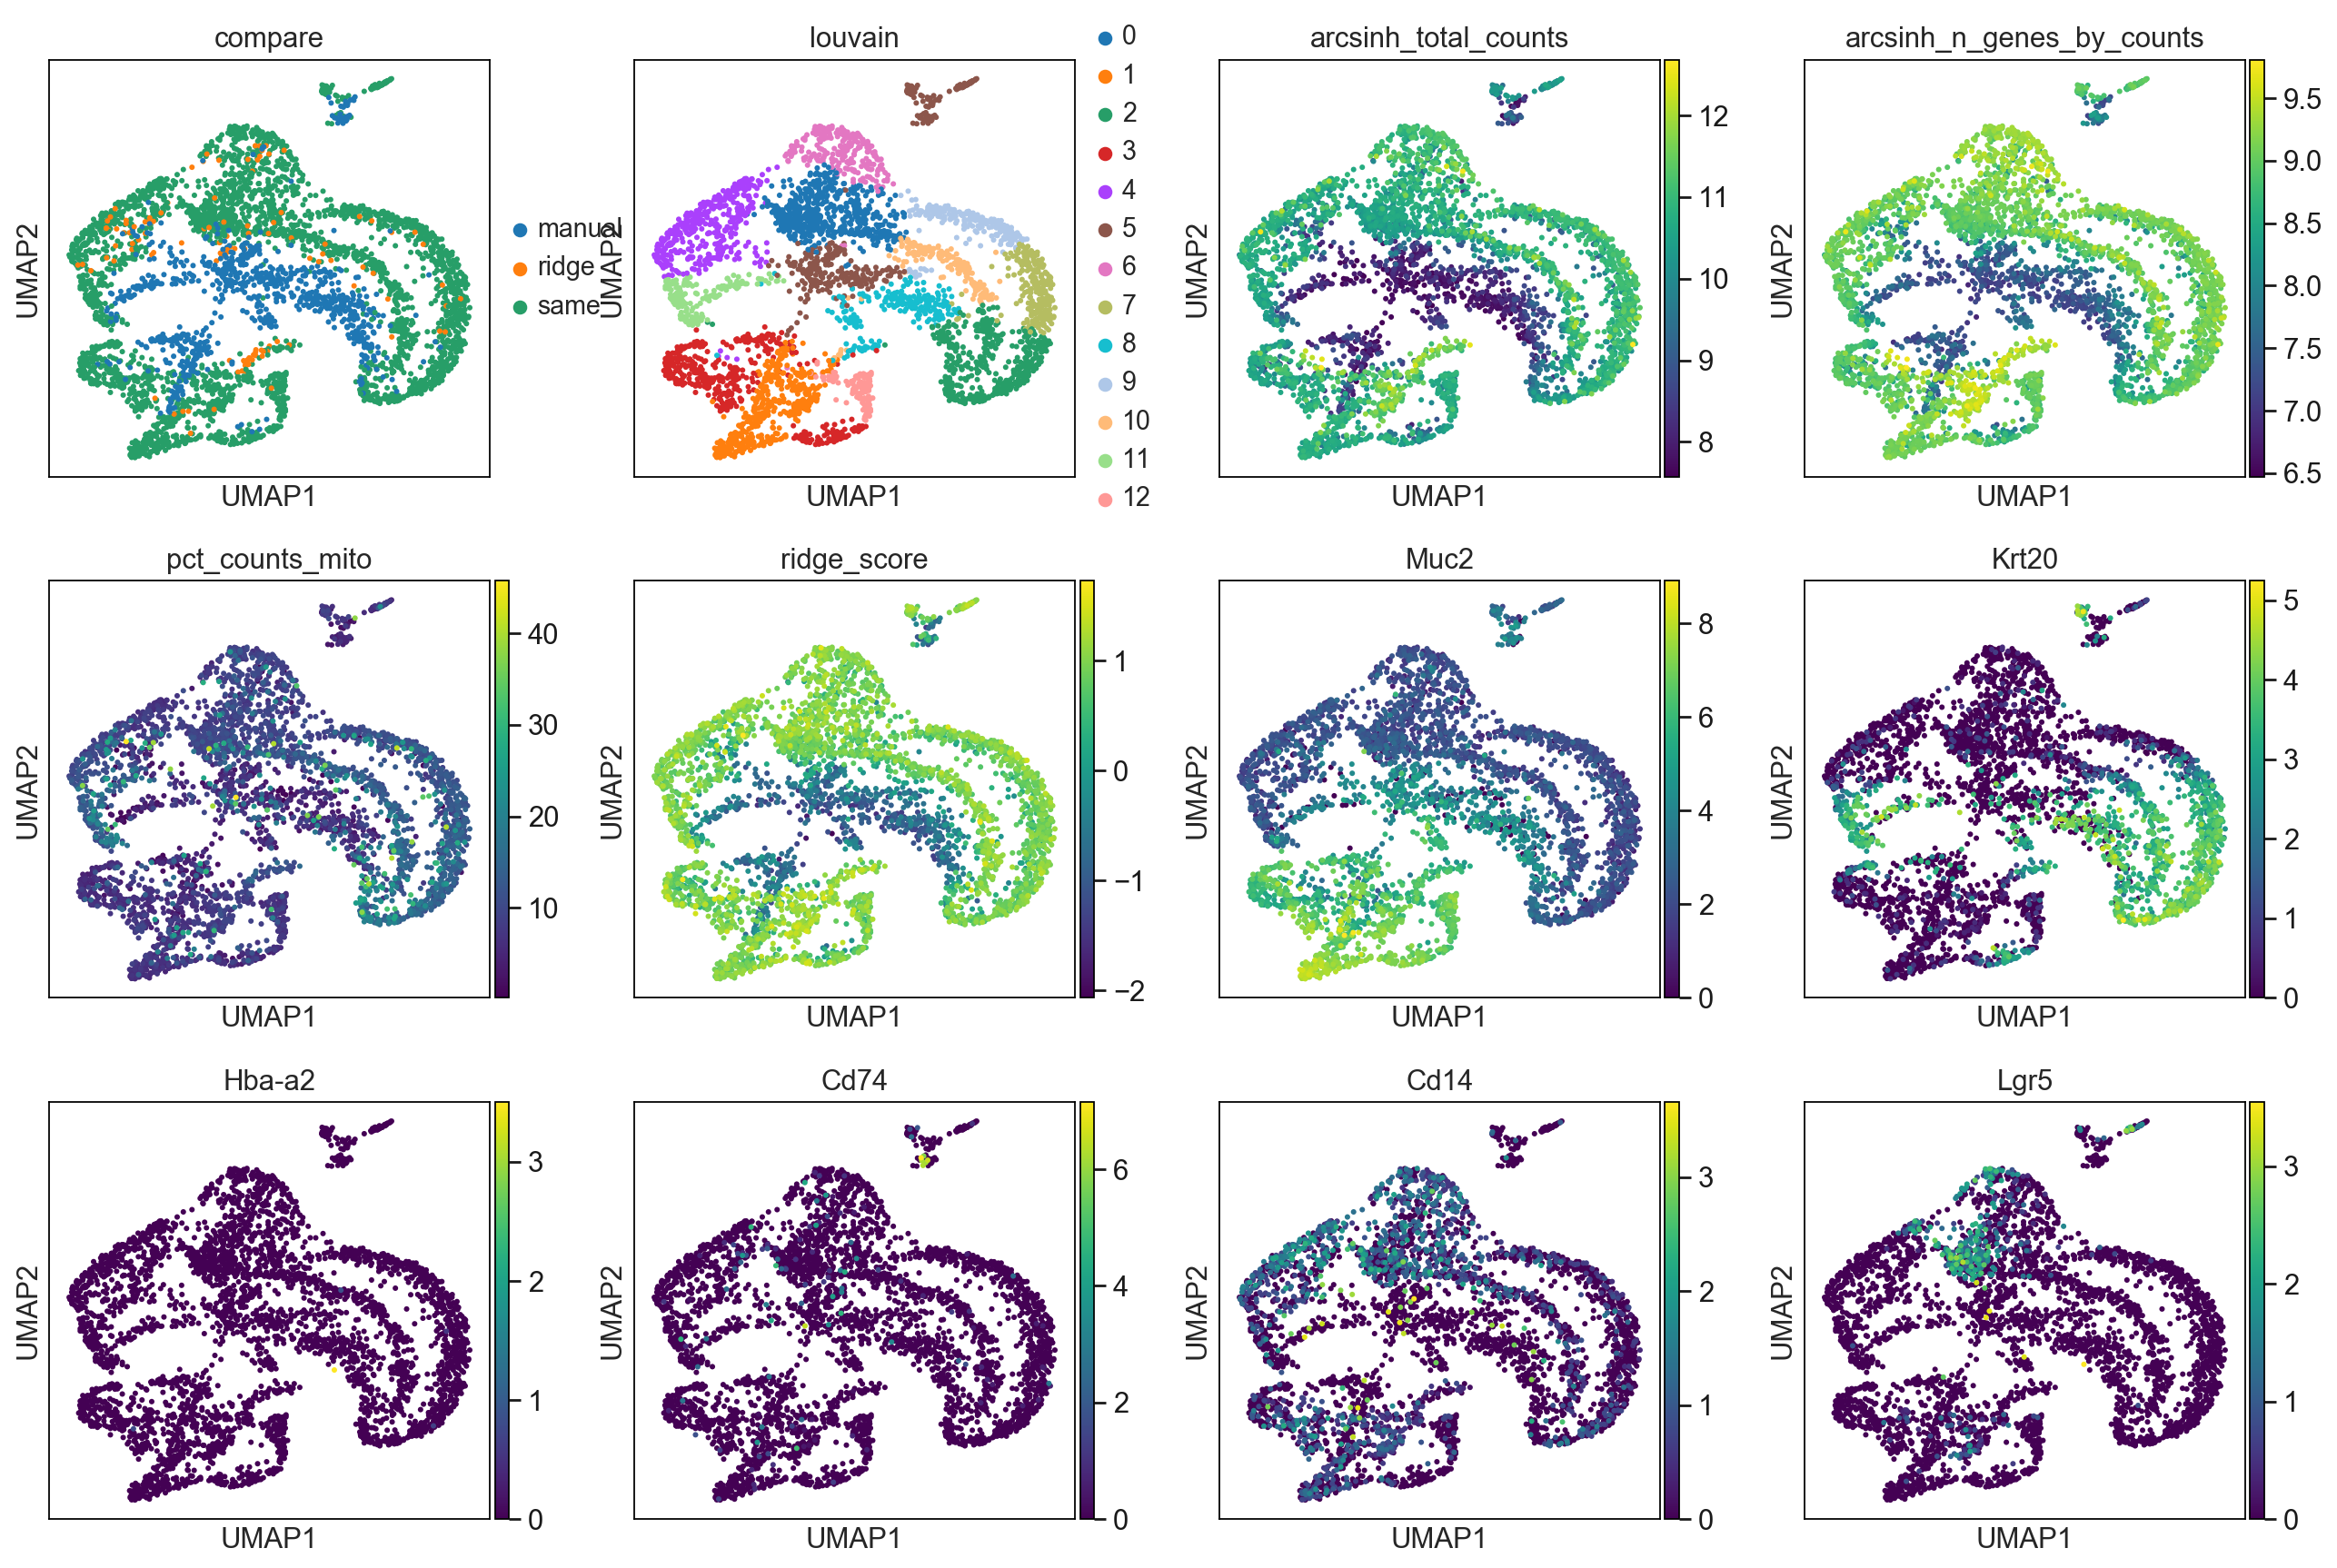

In [30]:
sc.pl.umap(s2_union, color=['compare','louvain','arcsinh_total_counts','arcsinh_n_genes_by_counts','pct_counts_mito','ridge_score','Muc2','Krt20','Hba-a2','Cd74','Cd14','Lgr5'])

In [31]:
s2_union.X = s2_union.layers['raw_counts'].copy()
s2_union.write('../data/colon_10X_unionfilt.h5ad', compression='gzip')

---
### Read cNMF results

In [33]:
cnmf_load_results(s2_union, '../data/cNMF/', 'colon_10X_union', k=11, dt=0.1)

ValueError: Some errors were detected !
    Line #312 (got 2 columns instead of 1)
    Line #1418 (got 2 columns instead of 1)
    Line #1901 (got 2 columns instead of 1)

In [ ]:
s2_union.obs.columns

In [ ]:
sc.pl.umap(s2_union, color=['compare', 'louvain', 'usage_1', 'usage_2',
       'usage_3', 'usage_4', 'usage_5', 'usage_6', 'usage_7', 'usage_8',
       'usage_9', 'usage_10', 'usage_11'])

In [ ]:
sc.pl.violin(s2_union, keys=['usage_1','usage_2',
       'usage_3', 'usage_4', 'usage_5', 'usage_6','usage_7','usage_8',
       'usage_9', 'usage_10','usage_11',], groupby='compare', stripplot=False)

In [ ]:
from scipy.stats import mannwhitneyu

In [ ]:
mannwhitneyu(s2_union.obs.loc[s2_union.obs['compare']=='manual','usage_1'], s2_union.obs.loc[s2_union.obs['compare']=='ridge','usage_1'], alternative='two-sided')

In [ ]:
s2_union.uns['cnmf_markers']